In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
data = pd.read_csv('FYP_SentimentAnalysis/BTCUSD_14 jan_cleaned.csv', index_col=['Date'])

In [5]:
data.head(10)

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
29/04/2013,134.44,147.49,134.00,144.54,0.0,1.603769e+09
30/04/2013,144.00,146.93,134.05,139.00,0.0,1.542813e+09
01/05/2013,139.00,139.89,107.72,116.99,0.0,1.298955e+09
02/05/2013,116.38,125.60,92.28,105.21,0.0,1.168517e+09
03/05/2013,106.25,108.13,79.10,97.75,0.0,1.085995e+09
04/05/2013,98.10,115.00,92.50,112.50,0.0,1.250317e+09
05/05/2013,112.90,118.80,107.14,115.91,0.0,1.288693e+09
06/05/2013,115.98,124.66,106.64,112.30,0.0,1.249023e+09
07/05/2013,112.25,113.44,97.70,111.50,0.0,1.240594e+09


In [6]:
data.shape

(2451, 6)

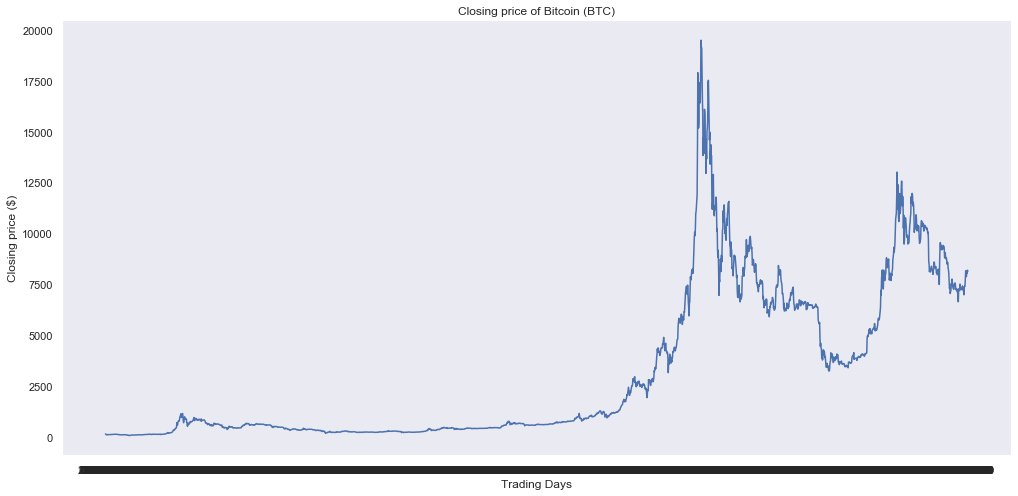

In [7]:
# Exploratory data analysis
plt.figure(figsize=(17, 8))
plt.plot(data.Close)
plt.title('Closing price of Bitcoin (BTC)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading Days')
plt.grid(False)
plt.show()

In [2]:
# Moving average
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

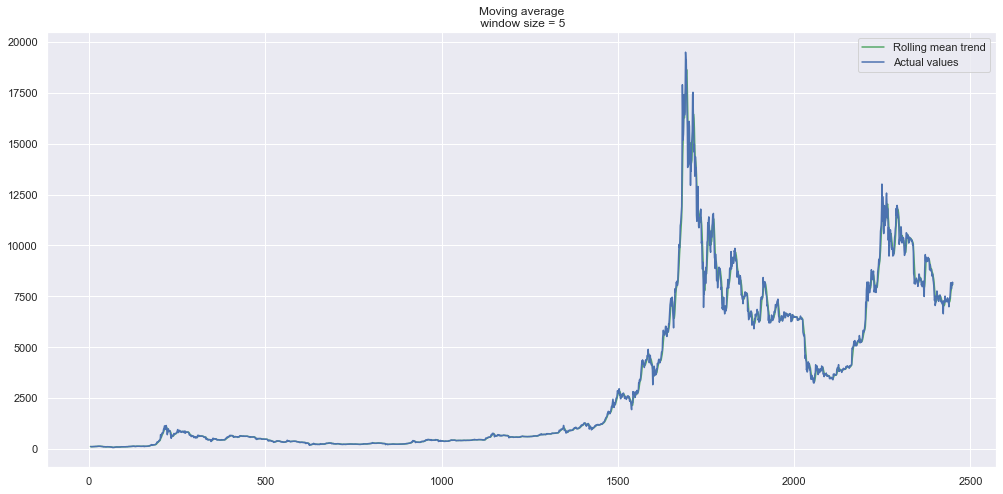

In [12]:
#Smooth by the previous 5 days (by week)
plot_moving_average(data.Close, 5)

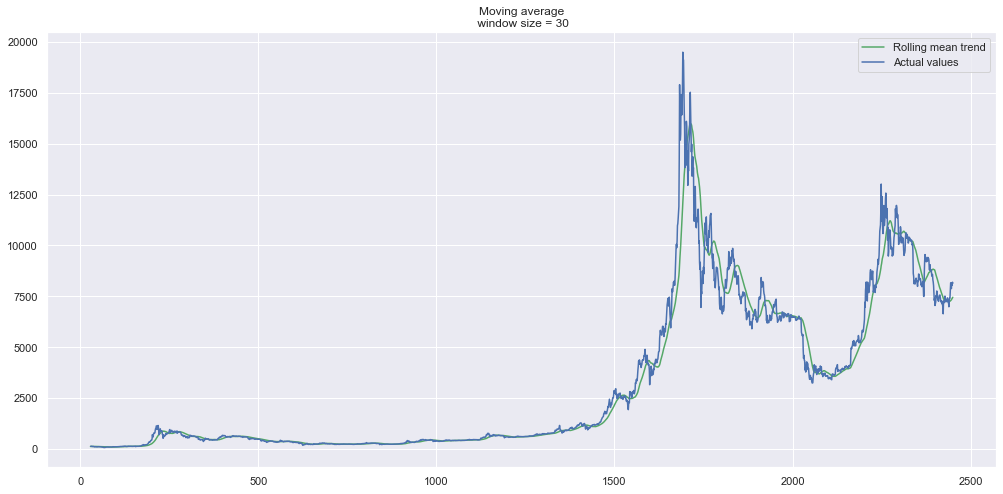

In [13]:
#Smooth by the previous month (30 days)
plot_moving_average(data.Close, 30)

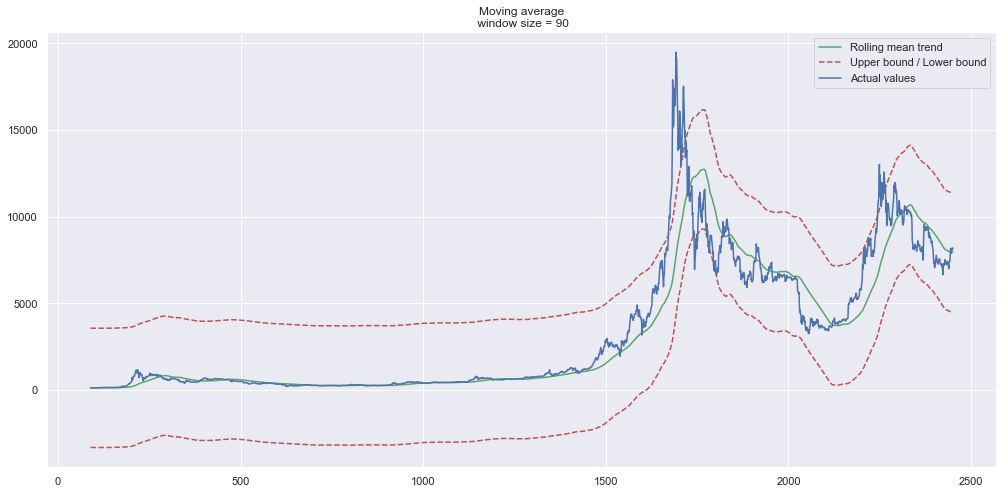

In [14]:
#Smooth by previous quarter (90 days)
plot_moving_average(data.Close, 90, plot_intervals=True)

In [15]:
# Exponential smoothing
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [16]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

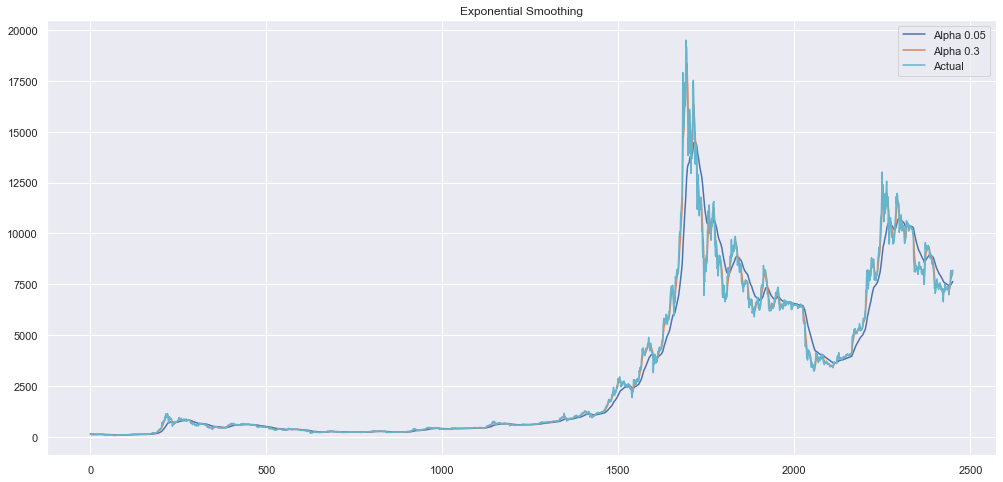

In [17]:
plot_exponential_smoothing(data.Close, [0.05, 0.3])

In [19]:
# Double exponential smoothing
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [20]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

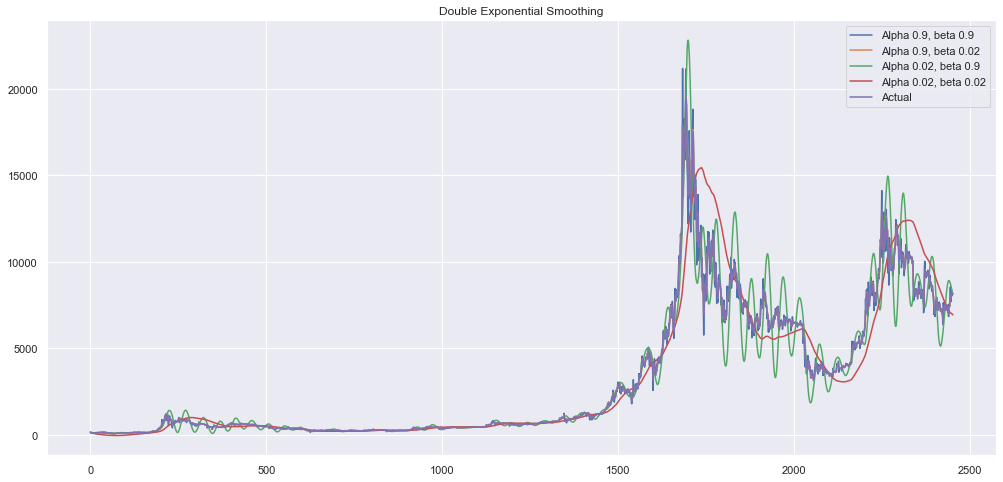

In [21]:
plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

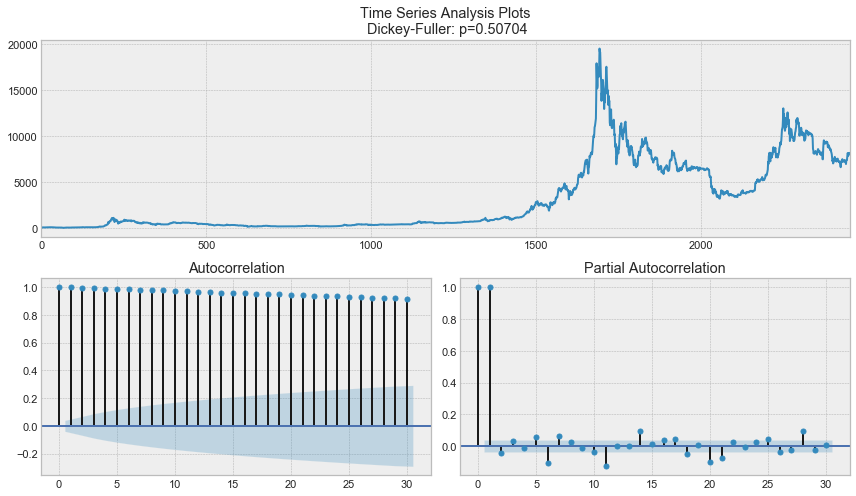

In [22]:
# Stationarity
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.Close, lags=30)

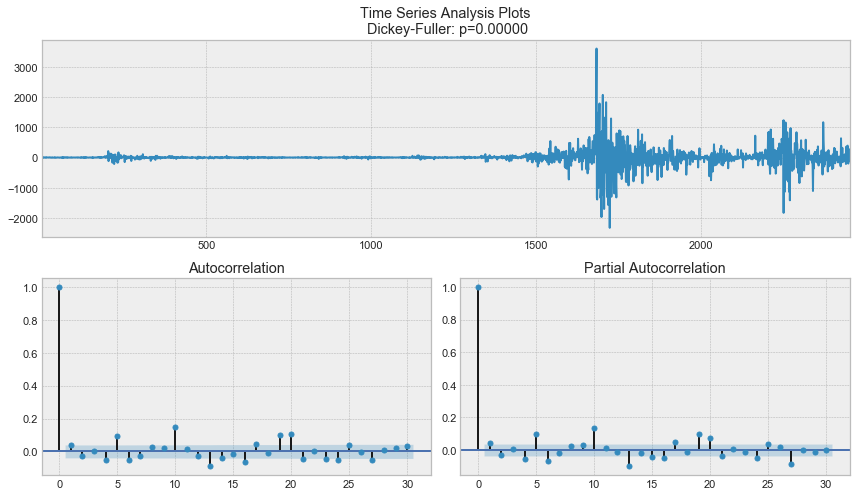

In [23]:
data_diff = data.Close - data.Close.shift(1)
tsplot(data_diff[1:], lags=30)

In [24]:
# SARIMA
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [26]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.Close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)